# MSc thesis part 1: main script

### Several functions have been defined and are saved in separate files
### Author: Pim Arendsen

In [19]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import utils, transforms, models
from torch.autograd import Variable
import nbimporter
import cv2
from PIL import Image
import random
from tqdm import tqdm_notebook
import pickle

#import functions from other files
from p1_CreateTrainingDataframe import CreateTrainingDataframe
from p1_CreateTestDataframe import CreateTestDataframe
from p1_BrodenDataSet import BrodenDataset
from p1_RescaleImage import Rescale
from p1_TransformToTensor import ToTensor
from p1_GetVectorFromImage import GetVector

## Part 1.1: Download a pretrained ResNet50 and edit the last layers

Download a pretrained model and define the layer from which to extract the image vectors

In [2]:
basenet = models.resnet50(pretrained=True)
out_layer = basenet._modules.get('avgpool')

## Part 1.2: Define the concepts in the Broden dataset

Define directories of the different folders. 
Set the working directory and change the directories accordingly

In [3]:
broden_dataset_path = '../data/broden1_384/'
index_file_path = os.path.join(broden_dataset_path, 'index.csv')
label_file_path = os.path.join(broden_dataset_path, 'label.csv')

Create training dataset by parsing through the Broden dataset. The data is already split in 70% train and 30% test data

In [4]:
REBUILD_DATA = False #set a manual flag to prevent rebuilding the data once it is available

In [5]:
if REBUILD_DATA:
    
    # create the training data dataframe
    print('creating training dataset')
    training_data = CreateTrainingDataframe(index_file_path, label_file_path, broden_dataset_path)
    print('writing training data...')    
    training_data.to_csv('../data/training_data.csv', index=False)
    
    # create the testdata dataframe
    test_data = CreateTestDataframe(index_file_path, label_file_path, broden_dataset_path)
    print('writing test data...')
    test_data.to_csv('../data/test_data.csv', index=False)
    print('Done')


If the training and test data is already available: update the following directories

In [6]:
training_data_path = '../data/training_data.csv'
test_data_path = '../data/test_data.csv'

## Part 1.3 Determine the CAV of the Broden dataset


The Broden dataset is converted into a PyTorch Dataset class, which can be used to access indivual images. <br>
The images are rescaled to 224x224 pixels, transformed to tensors and normalized according to the PyTorch documentation. <br>

The dataset returns a dictionary with the following keys: 
- 'image': as ndarray or tensor
- 'concept': a list of all the concepts within an image
- 'concept_vector': a one-hot array for each concept in the image

In [7]:
broden_dataset = BrodenDataset(csv_file=training_data_path, 
                               data_path = broden_dataset_path, 
                               transform = transforms.Compose([Rescale(224),
                                                              ToTensor(),
                                                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                    std=[0.229, 0.224, 0.225])
                                                              ]))

Next, a concept activation vector will be determined for one concept. This will be expanded further on in the project to multiple concepts. This requires several steps:
- get images for a specific concept
- get random images which do not contain the concept
- train a linear classifier between the concept and the random counter examples
- determine the vector orthogonal to the linear classifier in the direction of the concept, this is the CAV

**Questions to answers:**
- How to cope with the imbalanced dataset? Will this influence the concepts or the counter examples?
- What about miss classification of concepts in images?
- How many images (concept images as well as counter examples) are needed to get an accurate CAV?
- Do the amount of images need to be equal?

##### Get images for a specific concept

Define a concept to do some testing

In [8]:
concept = 'mountain'
num_imgs = 30

In [9]:
training_data = pd.read_csv(training_data_path, sep=',')

Determine the row index values of the concept in the training dataframe and select the desired amount of random images

In [10]:
idxs = training_data.loc[training_data[concept] == 1, 'image'].index.tolist()

In [11]:
# set a seed to 'control' randomness
random.seed(123)

# different amount of imgs are available for different concepts, if the there are not enough imgs for a concept it will 
# be changed to the maximum amount of available imgs
if len(idxs) < num_imgs:
    num_imgs = len(idxs)

idx_imgs = random.sample(idxs, num_imgs)

In [12]:
print('The concept "%s" is present in %d images' % (concept, len(idxs)))

The concept "mountain" is present in 1808 images


Show a few images containing the concept

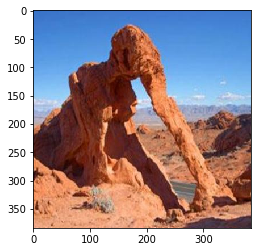

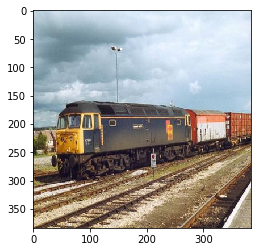

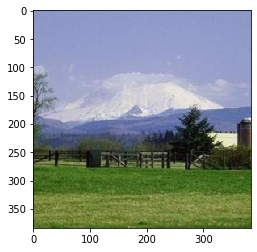

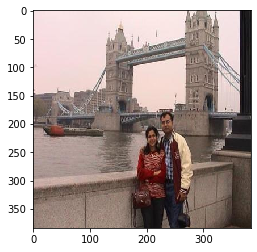

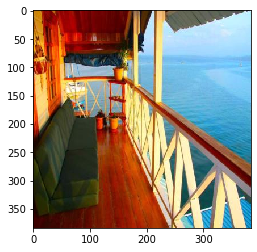

In [13]:
for i in range(5):
    plt.figure()
    plt.imshow(io.imread(os.path.join(broden_dataset_path, 'images/', training_data.loc[idxs[i], 'image'])))
    plt.show()

Not all images contain any mountains, so the images need to be filtered. <br>
Idea: extract feature vector for every image and use the cosine similarity to determine the closest images: See the example below from https://stackoverflow.com/questions/54042307/a-vector-and-matrix-rows-cosine-similarity-in-pytorch

In [14]:
x = torch.rand(10000,300)
y = torch.rand(1,300)
dist = F.cosine_similarity(x,y)
index_sorted = torch.argsort(dist)
top_1000 = index_sorted[:1000]
x[top_1000]

NameError: name 'F' is not defined

In [15]:
basenet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [18]:
#vector_dict = {}

#for idx in tqdm_notebook(idxs):
    sample = broden_dataset[idx]
    img = sample['image']
    img = img.float()
    vector_img = GetVector(img, basenet, out_layer)
    vector_dict[str(idx)] = vector_img

In [21]:
with open('../data/mountain_vectors.pickle', 'wb') as handle:
    pickle.dump(vector_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

To open the file use the following code

In [ ]:
with open('../data/mountain_vectors.pickle', 'rb') as handle:
    vec_dict = pickle.load(handle)

#### Get random counter examples

### Use this to determine to extract the image vectors

In [ ]:
test_img = broden_dataset[5]
t_img = test_img['image']
t_img = t_img.float()

To get the vector representing the image the network is set in 'evaluation' mode. <br>
*30-10-2019*: Currently, the GetVector function only works on a ResNet50 model and extract the vector from the 'avgpool' layer.

In [ ]:
basenet.eval()
t_img_vector = GetVector(t_img)
t_img_vector